In [17]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
import cv2
import utils.visualize_kits as vis
from utils.create_prompt import identify_box
from importlib import reload

# Load Data

In [19]:
image = nib.load("./kits23/dataset/case_00000/imaging.nii.gz").get_fdata()
seg = nib.load("./kits23/dataset/case_00000/segmentation.nii.gz").get_fdata()
instance_kidney = nib.load("./kits23/dataset/case_00000/instances/kidney_instance-1_annotation-1.nii.gz").get_fdata()
image.shape, seg.shape, instance_kidney.shape

((611, 512, 512), (611, 512, 512), (611, 512, 512))

In [ ]:
# Scale iamge to [0, 255] uint8 and turn to RGB
image_rgb = np.apply_along_axis(lambda x: cv2.cvtColor(x, cv2.COLOR_GRAY2RGB), axis=0, arr=cv2.convertScaleAbs(image)).squeeze(axis=1)

# Visualization

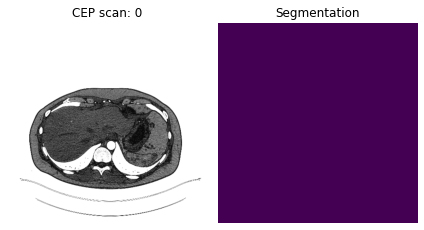

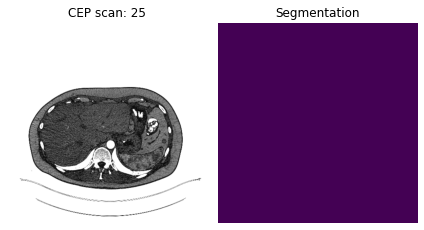

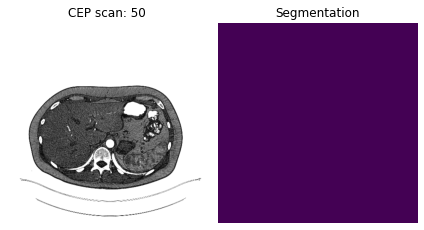

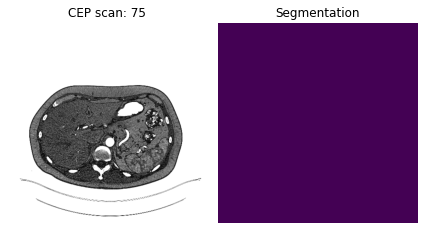

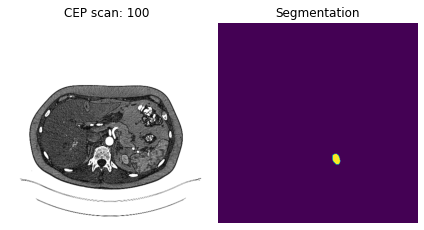

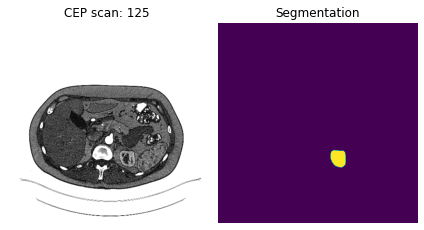

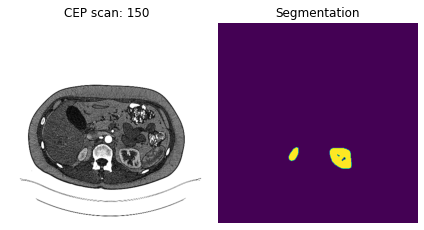

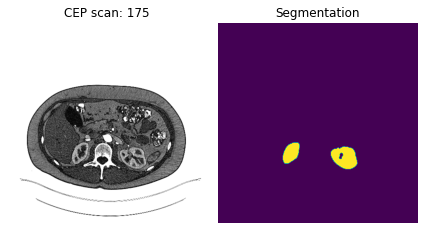

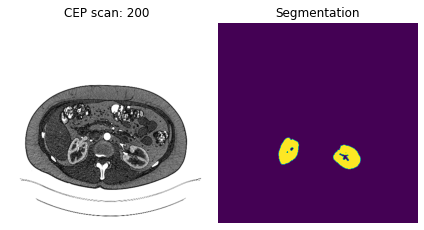

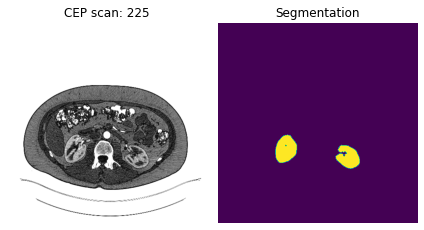

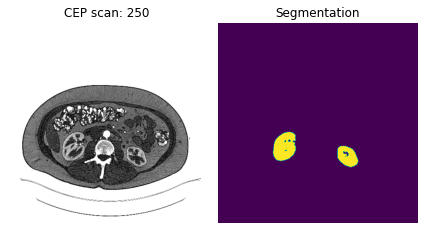

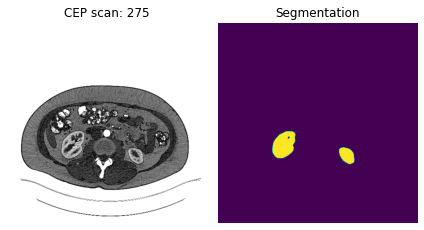

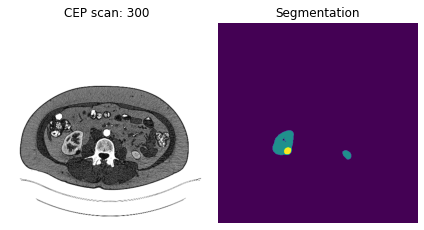

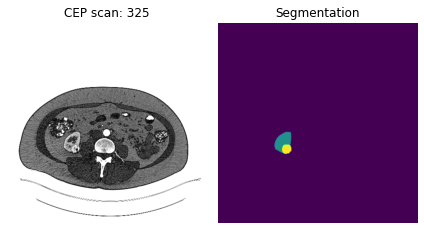

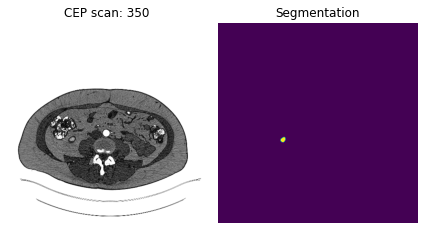

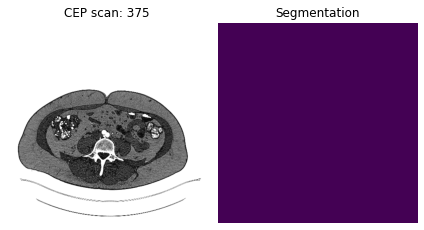

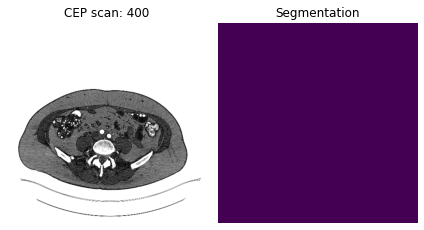

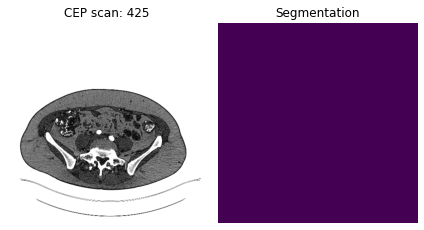

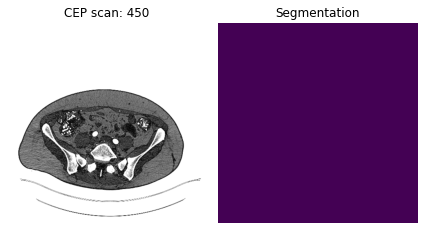

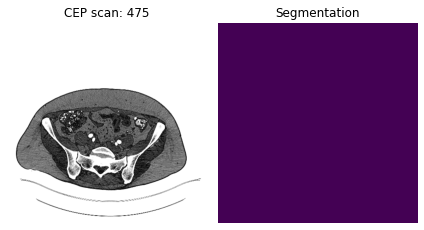

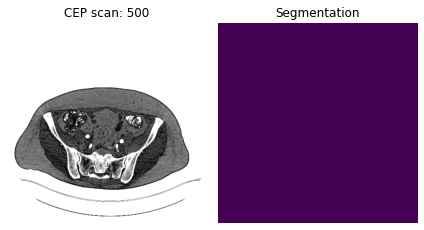

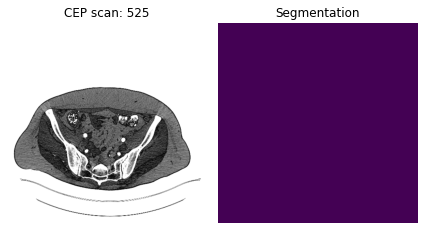

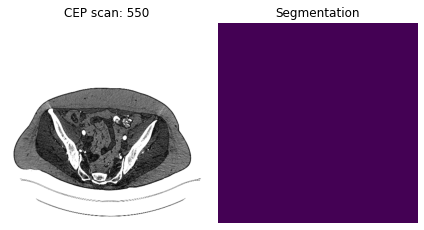

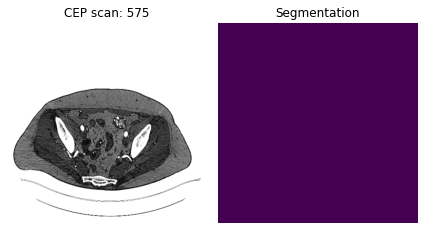

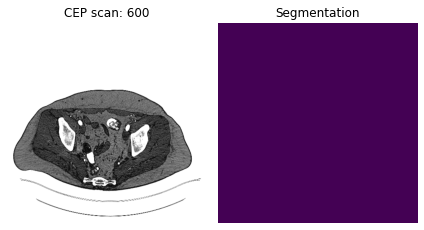

In [ ]:
# Visualize iamge, segment pair
vis.visualize3d_scan(image_rgb, seg, step_size=25)

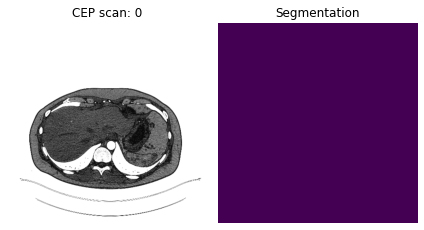

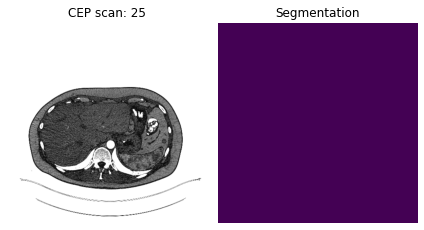

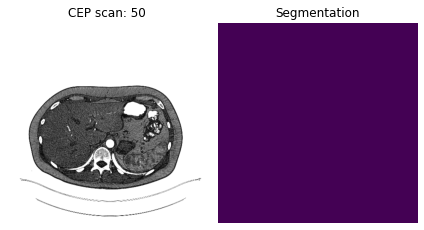

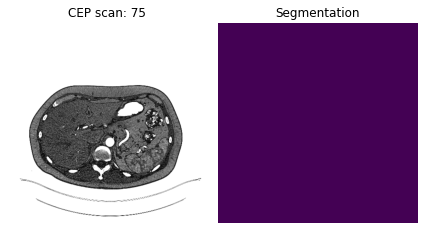

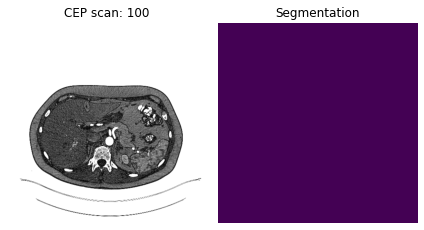

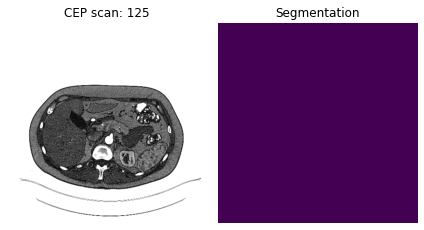

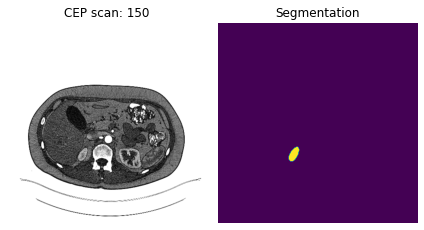

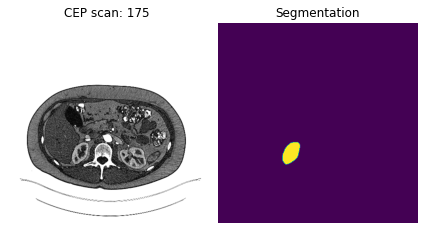

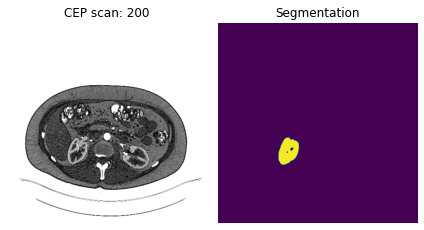

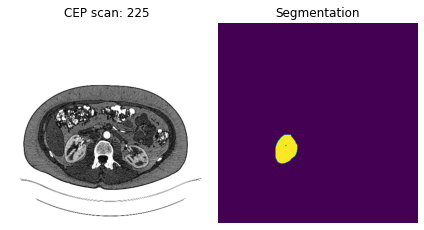

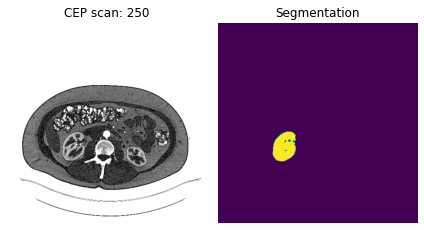

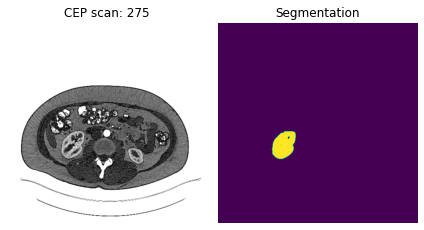

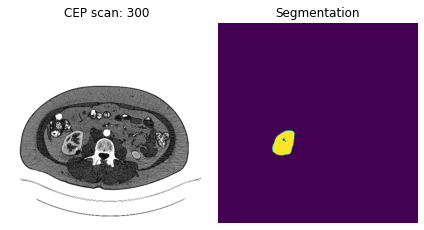

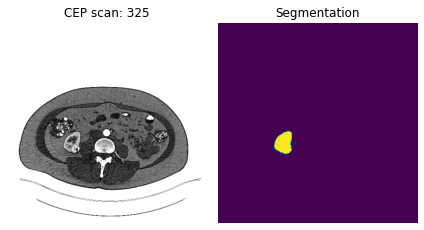

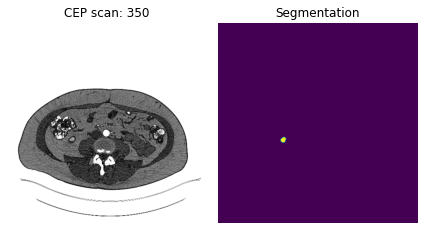

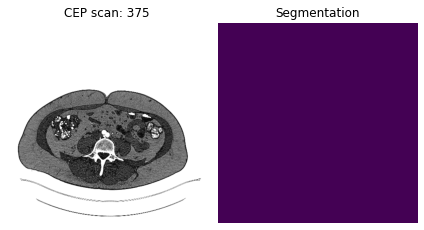

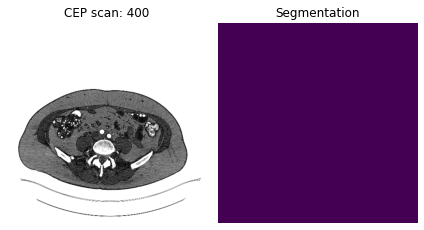

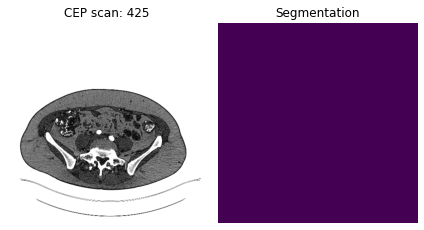

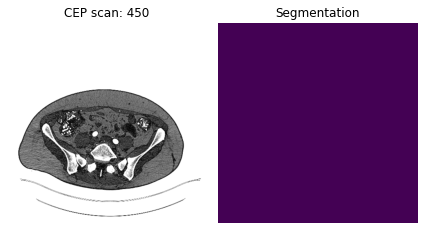

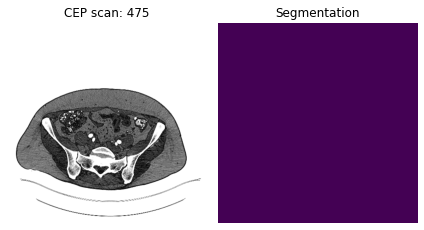

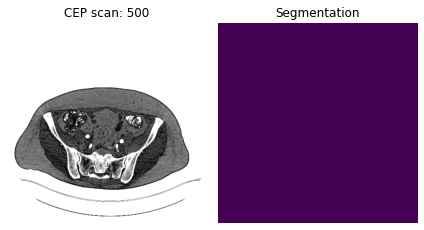

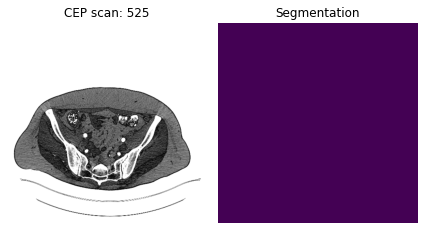

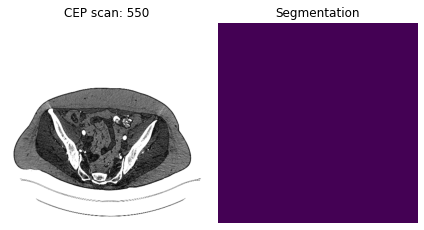

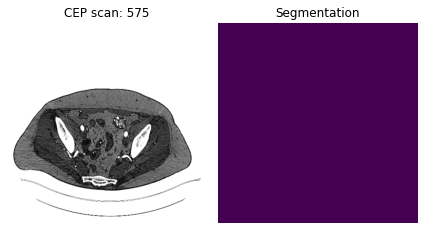

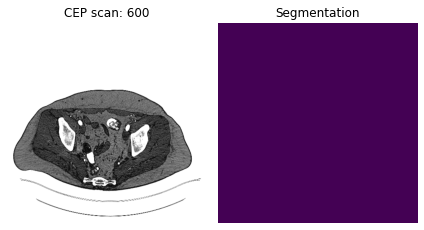

In [ ]:
# Visualize only kidney instance
# For each instance there is 3 independent annotations, which are almost identical.
vis.visualize3d_scan(image_rgb, instance_kidney, step_size=25)

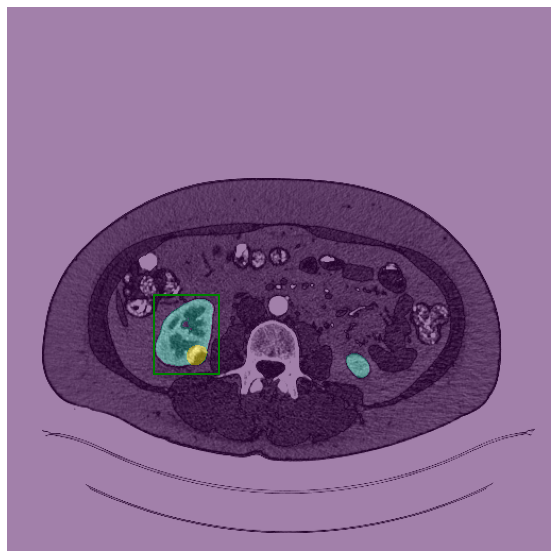

In [ ]:
# Generate a box over whole segment
box = identify_box(seg[300][None, :, :])
# Generate a box only over left kidney instance
box_kidney = identify_box(instance_kidney[300][None, :, :])
vis.visualize_segment(image_rgb, seg, slice=300, box=box_kidney[0])

# SAM Base

In [ ]:
# Model
sam_base = sam_model_registry["vit_b"]("./models/sam_vit_b_01ec64.pth")

In [ ]:
# Model details
sam_base.image_encoder  # Vision Transformer with randomly initialized PE [takes about 5 min per 3D image to embedd on google colab with the GPU] 207273 Parameters
sam_base.prompt_encoder # Returns sparse and dense embeddings (uses Randomly initialized positional embeddings) 598 Parameters
_ = sam_base.mask_decoder  # Uses transformer architecture to deccode image and prompt 30253 Parameters


## Single prompt Prediction

In [ ]:
# Try out model with box prompts possible: [point, masks, boxes, NLP prompt presented in paper but was not published]
predictor_base = SamPredictor(sam_base)
example_slice = image_rgb[300].transpose((1, 2, 0))
predictor_base.set_image(example_slice)

In [20]:
# Returns masks, scores and logits
masks, scores, _= predictor_base.predict(box=box_kidney[0])

In [22]:
box_kidney[0]

array([138, 271, 199, 345])

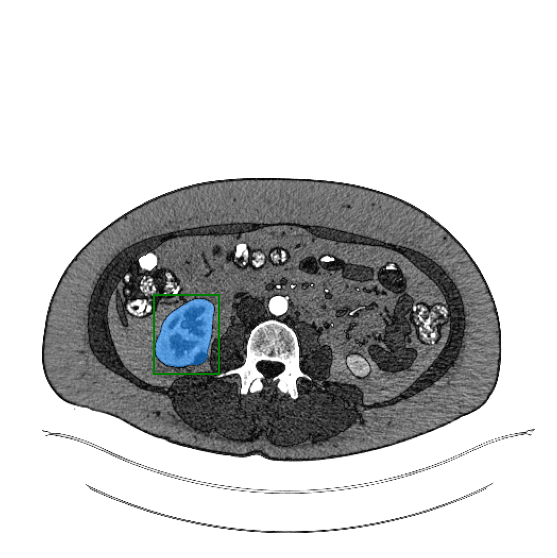

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(example_slice)
vis.show_mask(masks[0], plt.gca())
vis.show_box(box_kidney[0], plt.gca())
plt.axis('off')
plt.show()

## Automatic Mask Generation

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam_base)
masks = mask_generator.generate(example_slice)

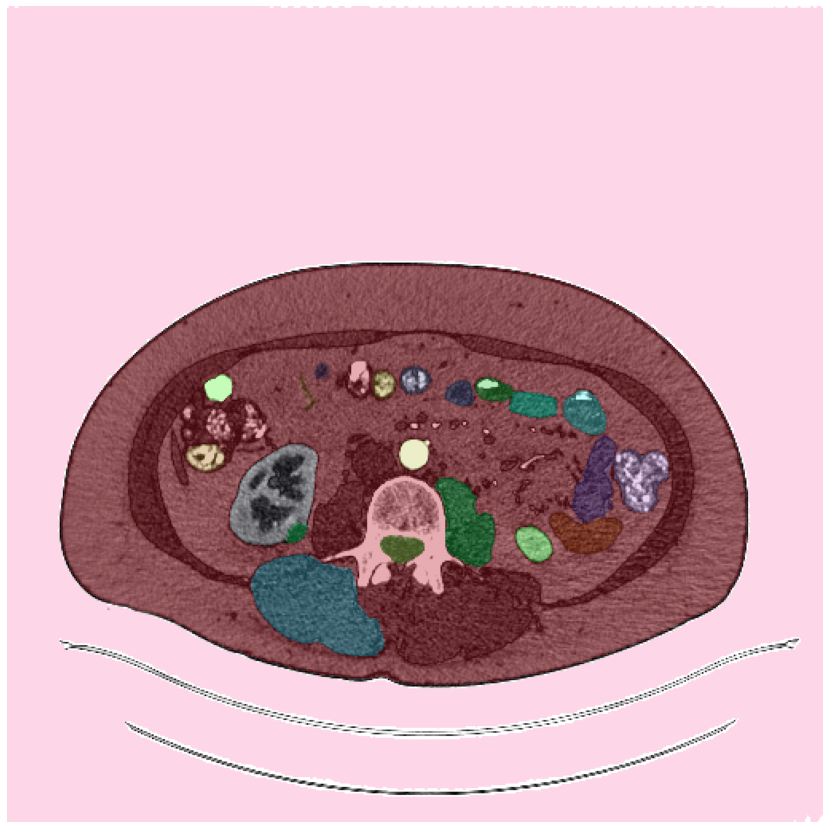

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(example_slice)
vis.show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
print(f"Total: {len(masks)}, masks with following meta_data: {masks[0].keys()}")
masks[2]

Total: 22, masks with following meta_data: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 2661,
 'bbox': [140.0, 275.0, 54.0, 63.0],
 'predicted_iou': 0.9876437187194824,
 'point_coords': [[184.0, 312.0]],
 'stability_score': 0.9847242832183838,
 'crop_box': [0, 0, 512, 512]}

* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

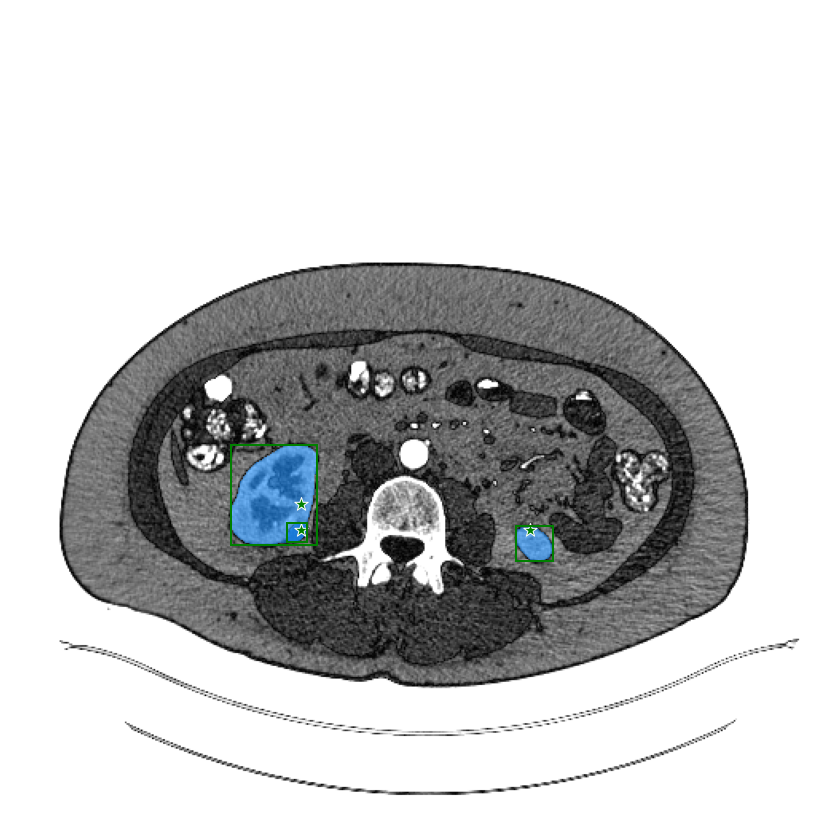

In [ ]:
# Visualize masks separately [2, 5, 18]
indices = [2, 5, 18]
plt.figure(figsize=(15, 15))
plt.imshow(example_slice)
for i in indices:
    vis.show_mask(masks[i]["segmentation"], plt.gca())
    vis.show_box(vis.transform_bbox(masks[i]["bbox"]), plt.gca())
    plt.gca().scatter(masks[i]["point_coords"][0][0], masks[i]["point_coords"][0][1], color='green', marker='*', edgecolor='white', s=200)
plt.axis("off")
plt.show()

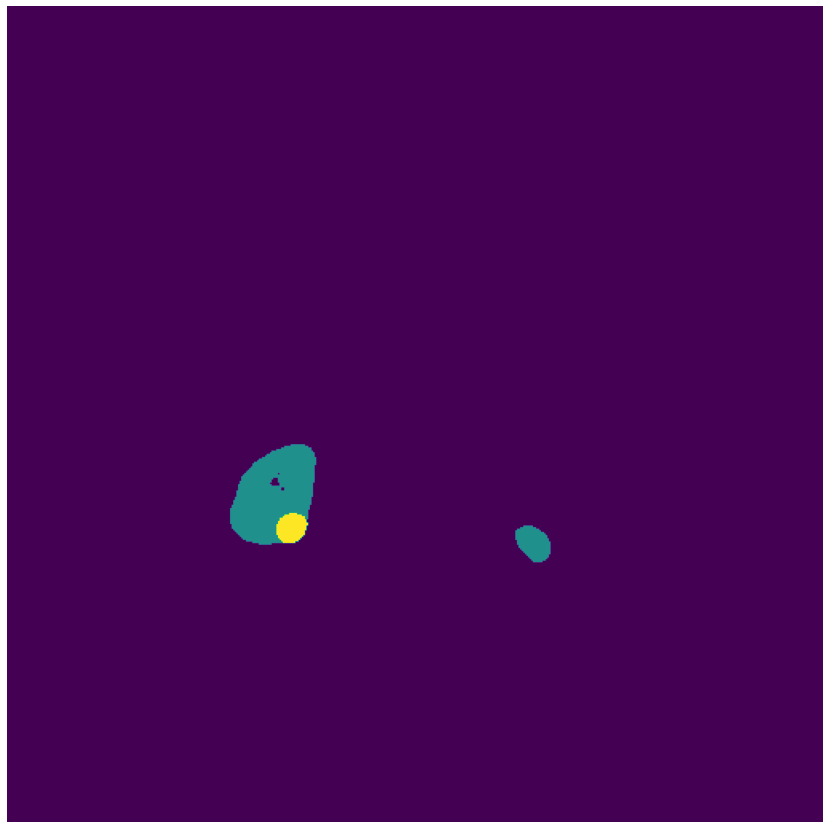

In [16]:
plt.figure(figsize=(15, 15))
plt.imshow(seg[300])
_ = plt.axis("off")

In [ ]:
# Playing around with the HyperParameters let you segment more precesily or more general taking longer, shorter time accordingly
# Very Precise search takes about 30 min per slice
mask_generator_base = SamAutomaticMaskGenerator(
    model=sam_base,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)